## Application of Algorithm A* to plan visits to tourist attractions in Italy

## Introduction:

### Motivation:

This project aims to present the characteristics and functioning of the A* (A-Star) search algorithm.


### Problem selection and objective states:

Problem domain: Proposal for a travel package from São Paulo to the 3 best-rated tourist attractions in Italy with the least expensive travel.

According to TripAdvisor (digital platform recognized as the largest travel website in the world), the best rated tourist attractions are:
- Sassi di Matera (Province of Taranto)
- St Peter's Basilica (Rome)
- Gardaland Park (Verona)

Therefore, the proposed solution must present the least expensive route to be taken for a tourist who intends to visit these three points.

Considering the context of search agents, it is possible to say that the three destinations can be considered the objective states of the problem, as long as at the end of the algorithm execution, all of them have been visited. While the starting point will be São Paulo.

## Methodology:


### Data structure:

The data structure of this project is composed of a graph, a table of straight-line distances between stations, a table of average hotel prices in the region of each station and a table of heuristics that is the result of processing the information presented by the two previous tables.

In [ ]:
# This class represent a graph
class Graph:

    # Initialize the class
    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    # Create an undirected graph by adding symmetric edges
    def make_undirected(self):
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.graph_dict.setdefault(b, {})[a] = dist

    # Add a link from A and B of given distance, and also add the inverse link if the graph is undirected
    def connect(self, A, B, distance=1):
        self.graph_dict.setdefault(A, {})[B] = distance
        if not self.directed:
            self.graph_dict.setdefault(B, {})[A] = distance

    # Get neighbors or a neighbor
    def get(self, a, b=None):
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    # Return a list of nodes in the graph
    def nodes(self):
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)

In [ ]:
# This class represent a node
class Node:

    # Initialize the class
    def __init__(self, name:str, parent:str):
        self.name = name
        self.parent = parent
        self.g = 0 # Distance to start node
        self.h = 0 # Distance to goal node
        self.f = 0 # Total cost

    # Compare nodes
    def __eq__(self, other):
        return self.name == other.name

    # Sort nodes
    def __lt__(self, other):
         return self.f < other.f


This excerpt is an adaptation of the code provided by [annytab.com](https://www.annytab.com/a-star-search-algorithm-in-python/)[1] to the problem domain.

#### Layout of stations and the approximate cost of train routes in Italy

Rout costs          |  Main stations| SP - Italy
:-------------------------:|:-------------------------:|:-------------------------:
<img src="https://guiati9.dev/img/posts_img/cost-map-italy.png" width="400px"/>  |  <img src="https://guiati9.dev/img/posts_img/italy-train-map.png" width="400px"/> | <img src="https://guiati9.dev/img/posts_img/gflights.png" width="400px"/>
[Rick Steves - Travel Tips](https://www.ricksteves.com/travel-tips/transportation/trains/italy-rail-passes)[2]|[Maps Italy](https://maps-italy.com/map-of-train-routes-in-italy)[3]|[Google Flight Tracker[4]](https://www.google.com/travel/explore?g2lb=2502548%2C4258168%2C4260007%2C4270442%2C4274032%2C4291318%2C4305595%2C4306835%2C4308226%2C4317915%2C4326765%2C4328159%2C4329288%2C4366684%2C4373848%2C4381263%2C4382624%2C4385383%2C4386665%2C4395397%2C4270859%2C4284970%2C4291517%2C4316256%2C4356900&hl=en&gl=br&un=1&tfs=CBkQAxopEgoyMDIwLTA2LTMwag0IAhIJL20vMDIycGZtcgwIBBIIL20vMDNyamoaKRIKMjAyMC0wNy0wNGoMCAQSCC9tLzAzcmpqcg0IAhIJL20vMDIycGZtQAFIAVIDQlJMcAE&curr=BRL&authuser=0&origin=https%3A%2F%2Fwww.google.com&gsas=1)



#### Graph generated from approximate cost, map of stations and available flights

<img src="https://guiati9.dev/img/italy_routes_prices_5.png" width="1000px"/>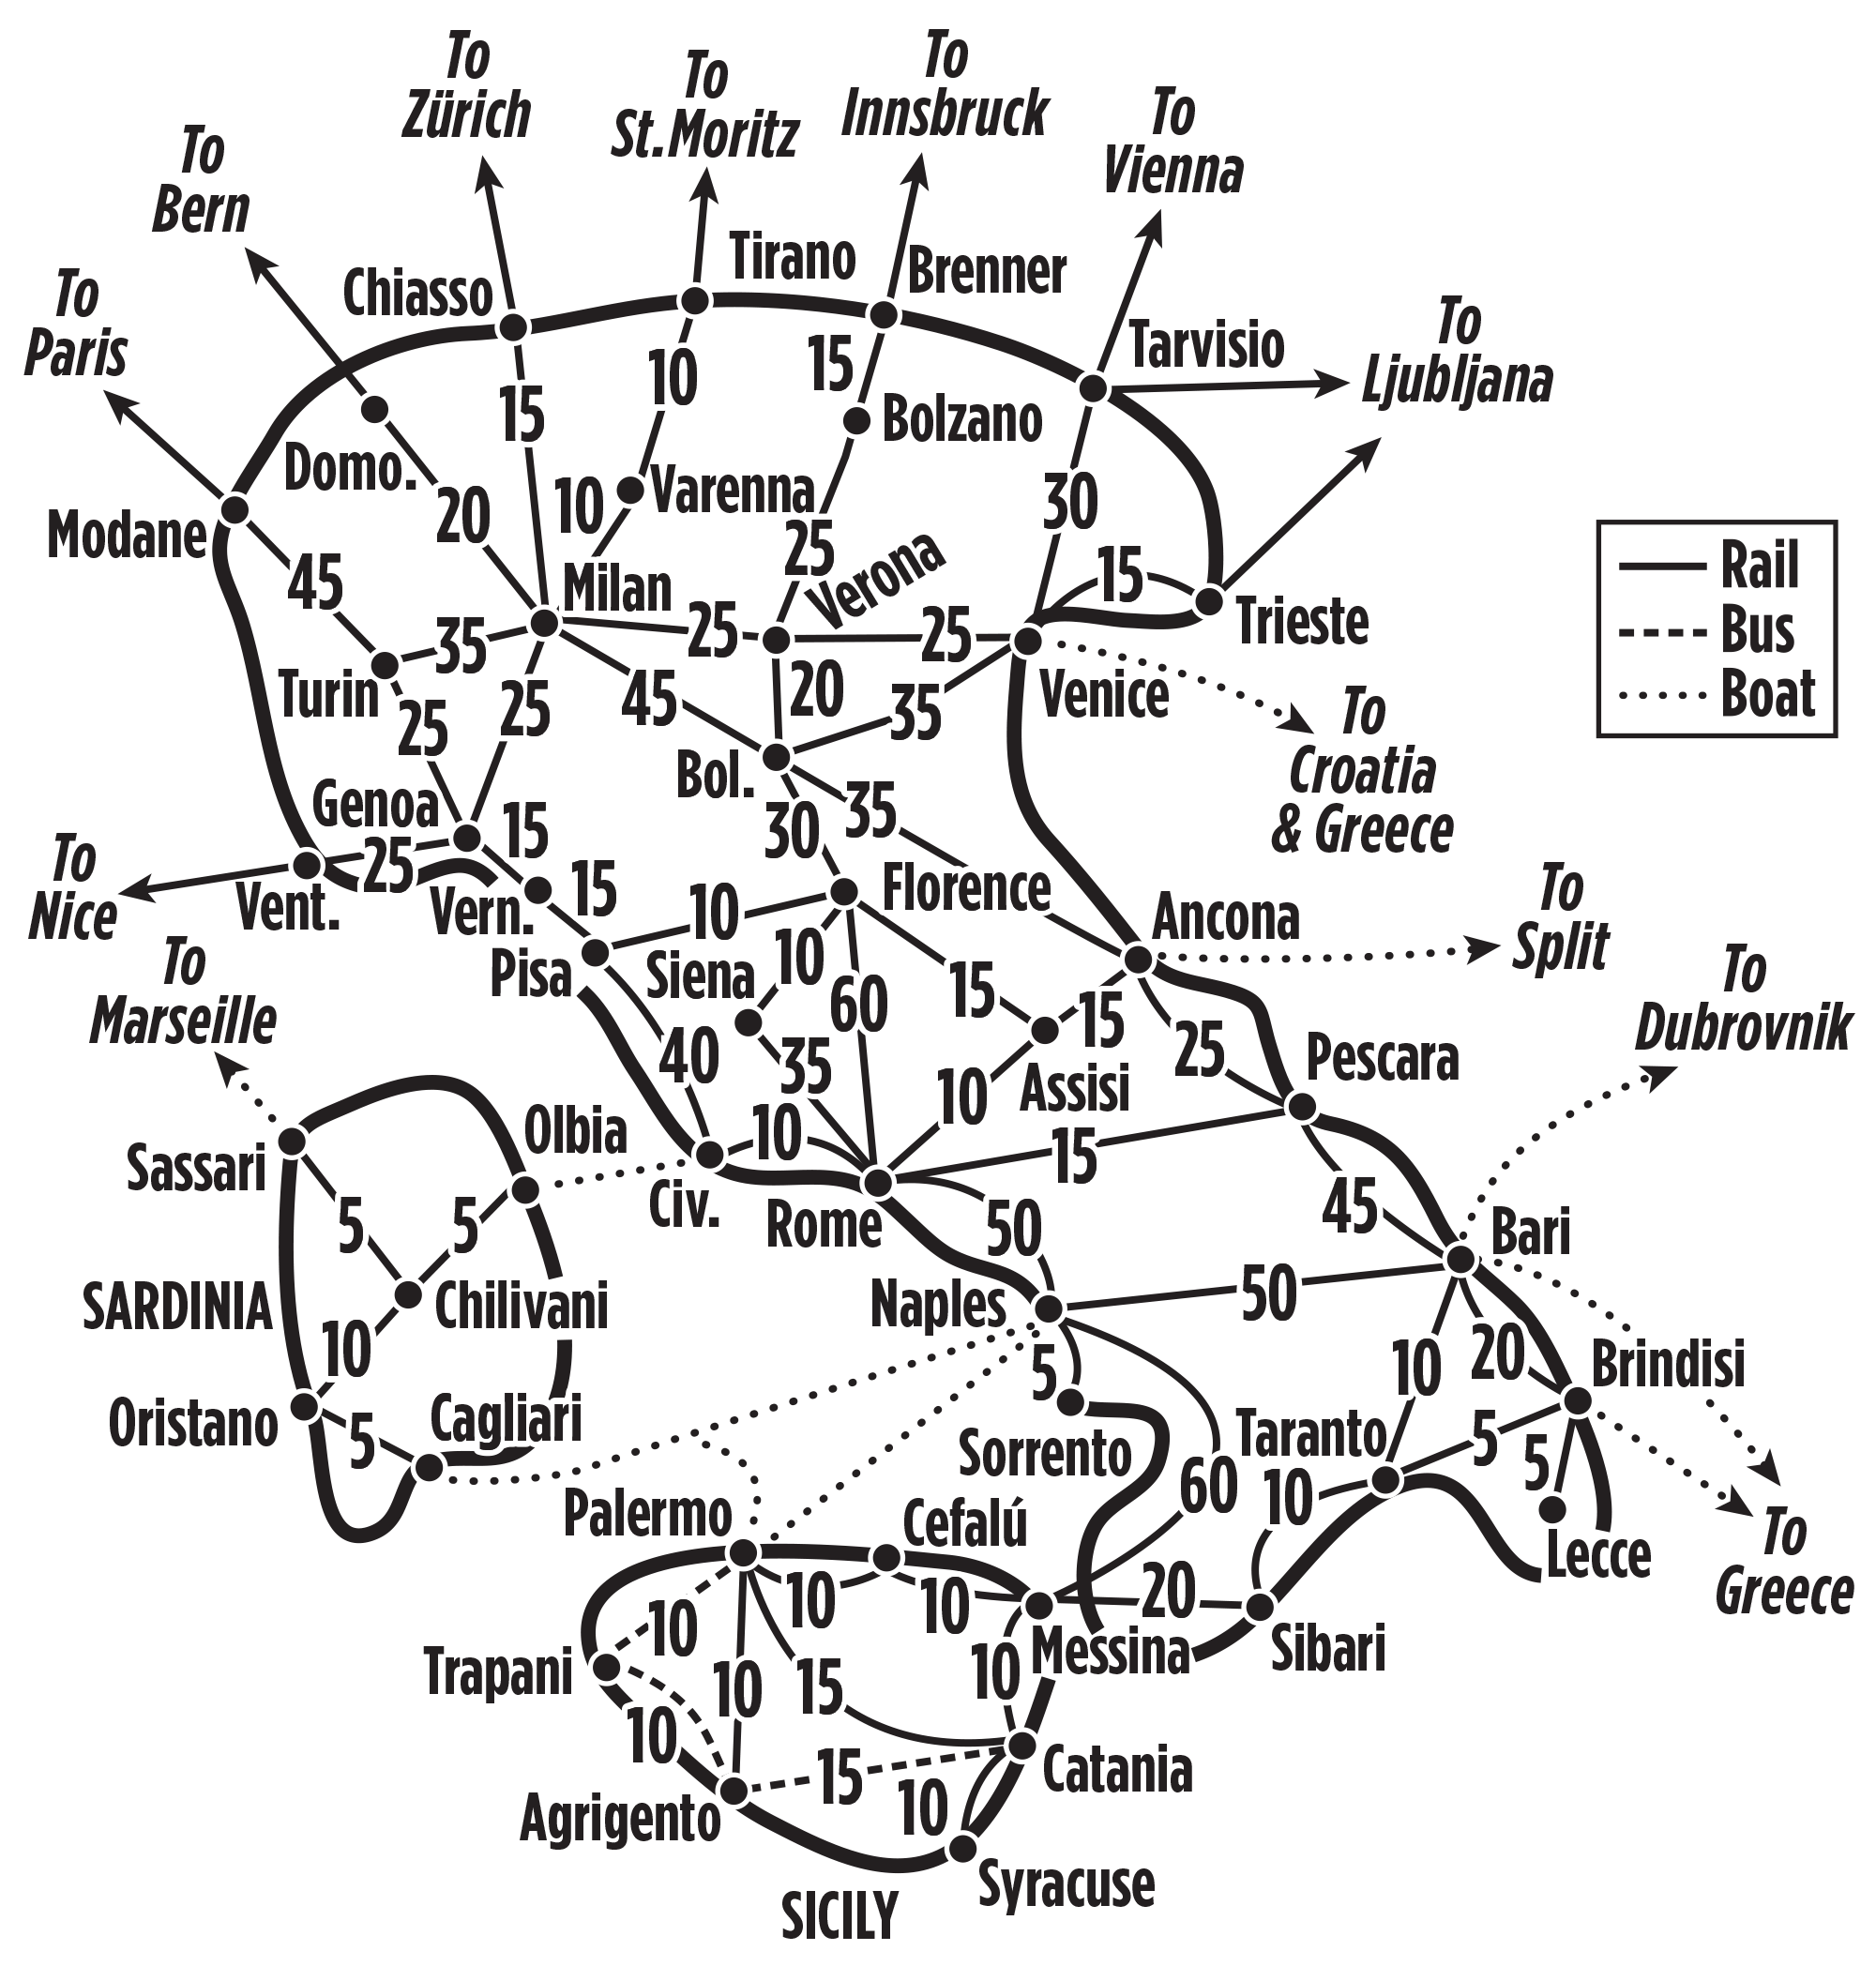

In [ ]:
# Create a graph
graph = Graph()
graph.connect('SP', 'Rome', 5560)
graph.connect('SP', 'Bologna', 6310)
graph.connect('SP', 'Milano', 5688)
graph.connect('SP', 'Venice', 4658)
graph.connect('Reggio di Calabria', 'Taranto', 149)
graph.connect('Reggio di Calabria', 'Naples', 323)
graph.connect('Lecce', 'Brindisi', 25)
graph.connect('Brindisi', 'Bari', 99)
graph.connect('Bari', 'Taranto', 49)
graph.connect('Bari', 'Foggia', 124)
graph.connect('Taranto', 'Naples', 149)
graph.connect('Naples', 'Foggia', 248)
graph.connect('Foggia', 'Pescara', 124)
graph.connect('Naples', 'Rome', 248)
graph.connect('Rome', 'Pescara', 74)
graph.connect('Pescara', 'Ancona', 74)
graph.connect('Rome', 'Ancona', 124)
graph.connect('Rome', 'Florence', 248)
graph.connect('Rome', 'Pisa', 248)
graph.connect('Pisa', 'Florence', 49)
graph.connect('Florence', 'Bologna', 149)
graph.connect('Bologna', 'Ancona', 174)
graph.connect('Pisa', 'Genoa', 149)
graph.connect('Genoa', 'Bologna', 124)
graph.connect('Genoa', 'Torino', 124)
graph.connect('Genoa', 'Milano', 124)
graph.connect('Milano', 'Bologna', 223)
graph.connect('Bologna', 'Verona', 99)
graph.connect('Bologna', 'Venice', 174)
graph.connect('Venice', 'Trieste', 74)
graph.connect('Venice', 'Verona', 124)
graph.connect('Verona', 'Milano', 124)
graph.connect('Milano', 'Torino', 174)
graph.connect('Verona', 'Bolzano', 124)

# Make graph undirected, create symmetric connections
graph.make_undirected()

In [ ]:
#importing spreadsheets to feed heuristic function
import pandas as pd
import numpy as np
dist_linha_reta = pd.read_csv("distancias_estacoes_italia.csv", index_col = 0)
precos_hotel = pd.read_csv("precos_hotel.csv")

precos_hotel = precos_hotel
tabela_heuristicas = dist_linha_reta

In [ ]:
precos_hotel

,Unnamed: 0,Bolzano,Verona,Milano,Torino,Trieste,Venice,Bologna,Genoa,Pisa,...,Pescara,Naples,Foggia,Bari,Brindisi,Lecce,Taranto,Reggio di Calabria,SP,Unnamed: 22
0,NaN,326,75,84,155,170,145,178,178,117,...,238,95,223,106,237,167,145,150,60,NaN


In [ ]:
tabela_heuristicas

,Bolzano,Verona,Milano,Torino,Trieste,Venice,Bologna,Genoa,Pisa,Florence,...,Rome,Pescara,Naples,Foggia,Bari,Brindisi,Lecce,Taranto,Reggio di Calabria,SP
Bolzano,0,124,209,325,207,139,223,297,315,305,...,518,501,668,651,744,832,878,821,995,9701
Verona,124,0,138,263,218,98,107,199,197,185,...,411,421,576,575,676,778,813,748,901,9606
Milano,209,138,0,131,356,243,200,120,218,249,...,480,524,659,677,786,892,925,857,975,9502
Torino,325,263,131,0,480,365,296,125,264,318,...,525,600,713,753,865,971,1004,931,1022,9382
Trieste,207,218,356,480,0,114,228,404,342,288,...,429,358,535,487,563,653,690,640,853,9790
Venice,139,98,243,365,114,0,130,290,246,204,...,393,366,534,513,605,701,739,680,861,9685
Bologna,223,107,200,296,228,130,0,192,116,84,...,304,325,471,480,587,690,725,657,797,9564
Genoa,297,199,120,125,404,290,192,0,141,199,...,403,480,592,631,744,849,884,810,900,9411
Pisa,315,197,218,264,342,246,116,141,0,69,...,264,340,450,489,604,709,742,668,764,9451
Florence,305,185,249,318,288,204,84,199,69,0,...,232,281,409,435,546,652,686,613,729,9503


### Adopted heuristic function:

#### h(n) = d * p / 100

The chosen heuristic formula defines h(n) as the product of the distance from the station in a straight line and the average price of hotels in the station region divided by 100.

The division by 100 is done to reduce, proportionally to all stations, the value of the heuristic in order to prevent it from overestimating the value of the cost of reaching the node (g(n)), that is, so that does not become an unacceptable heuristic.

In [ ]:
stations_list = list(tabela_heuristicas.columns.values)


tabela_heuristicas.T


def set_heuristics(station_name):
    station_index = stations_list.index(station_name)
    heuristics = [value for value in heuristics_dict.values()][station_index]
    return heuristics

#Aplicando heurística (distância em linha reta ao destino * preco médio de hotel na região/100)
dict_hoteis = precos_hotel.to_dict()
for station in stations_list:
    teste = tabela_heuristicas[station].to_dict()
    #print(station)
    #print(teste)
    for key in dict_hoteis:
        teste[key] = teste.get(key, 1) * dict_hoteis[station][0]/100
    for key in teste:
        tabela_heuristicas[station][key] = teste[key]
heuristics_dict = tabela_heuristicas.to_dict()

tabela_heuristicas


,Bolzano,Verona,Milano,Torino,Trieste,Venice,Bologna,Genoa,Pisa,Florence,...,Rome,Pescara,Naples,Foggia,Bari,Brindisi,Lecce,Taranto,Reggio di Calabria,SP
Bolzano,0,93,175,503,351,201,396,528,368,408,...,564,1192,634,1451,788,1971,1466,1190,1492,5820
Verona,404,0,115,407,370,142,190,354,230,247,...,447,1001,547,1282,716,1843,1357,1084,1351,5763
Milano,681,103,0,203,605,352,356,213,255,333,...,523,1247,626,1509,833,2114,1544,1242,1462,5701
Torino,1059,197,110,0,816,529,526,222,308,426,...,572,1428,677,1679,916,2301,1676,1349,1533,5629
Trieste,674,163,299,744,0,165,405,719,400,385,...,467,852,508,1086,596,1547,1152,928,1279,5874
Venice,453,73,204,565,193,0,231,516,287,273,...,428,871,507,1143,641,1661,1234,986,1291,5811
Bologna,726,80,168,458,387,188,0,341,135,112,...,331,773,447,1070,622,1635,1210,952,1195,5738
Genoa,968,149,100,193,686,420,341,0,164,266,...,439,1142,562,1407,788,2012,1476,1174,1350,5646
Pisa,1026,147,183,409,581,356,206,250,0,92,...,287,809,427,1090,640,1680,1239,968,1146,5670
Florence,994,138,209,492,489,295,149,354,80,0,...,252,668,388,970,578,1545,1145,888,1093,5701


### Search agent structure:

The search agent in this problem is the A* search algorithm which is implemented by the function ```astar_search()```, defined as:

In [ ]:
start_node_value = 0
def astar_search(graph, start, end, start_node_value):
    # Create lists for open nodes and closed nodes
    loops = -1
    open = []
    closed = []
    opened_list = []
    closed_list = []
    opened_list_entry = []
    closed_list_entry = []
    next_start_node_value = 0
    nodes_values = []
    heuristics = {}

    station_index = stations_list.index(end)
    heuristics = [value for value in heuristics_dict.values()][station_index]

    # Create a start node and an goal node
    start_node = Node(start, None)
    goal_node = Node(end, None)

    # Add the start node
    open.append(start_node)
    #To save last execution g value
    start_node.g = start_node.g + start_node_value
    # Loop until the open list is empty
    while len(open) > 0:
        opened_list_entry = []
        closed_list_entry = []

        loops = loops + 1

        #updating open list output
        opened_list_entry.append(loops)
        for i in open:
            opened_list_entry.append(i.__dict__['name'])
        opened_list.append(opened_list_entry)

        # Sort the open list to get the node with the lowest cost first
        open.sort()

        #updating closed list output
        closed_list_entry.append(loops)
        for i in closed:
            closed_list_entry.append(i.__dict__['name'])
        closed_list.append(closed_list_entry)

        # Get the node with the lowest cost
        current_node = open.pop(0)

        # Add the current node to the closed list
        closed.append(current_node)


        # Check if we have reached the goal, return the path
        if current_node == goal_node:
            path = []
            while current_node != start_node:
                path.append(current_node.name + ': ' + str(current_node.g))
                nodes_values.append(current_node.g)
                current_node = current_node.parent
            path.append(start_node.name + ': ' + str(start_node.g))
            # Return reversed path
            next_start_node_value = nodes_values[0]
            return path[::-1], opened_list, closed_list, next_start_node_value

        # Get neighbours
        neighbors = graph.get(current_node.name)

        # Loop neighbors
        for key, value in neighbors.items():

            # Create a neighbor node
            neighbor = Node(key, current_node)

            # Check if the neighbor is in the closed list
            if(neighbor in closed):
                continue

            # Calculate full path cost

            neighbor.g = current_node.g + graph.get(current_node.name, neighbor.name)
            neighbor.h = heuristics.get(neighbor.name)
            neighbor.f = neighbor.g + neighbor.h
            # Check if neighbor is in open list and if it has a lower f value
            if(add_to_open(open, neighbor) == True):
                # Everything is green, add neighbor to open list
                open.append(neighbor)
#                if neighbor not in open:
        #opened_list.append(opened_list_entry)
 #       close_list.append(closed_list)
    # Return None, no path is found
    return None

def print_results(path, opened_list, close_list, custo_total, start, end):
    print('Caminho de '+start+' à '+ end+':')
    print(path)
    print('\n')
    print('Custo:')
    print(custo_total)
    print('\n')
    print('Nós abertos por execução:')
    for i in opened_list:
        for j in i:
            print(j)
        print('------------')
    print('\n')
    print('Nós fechados por execução:')
    for i in close_list:
        for j in i:
            print(j)
        print('------------')
    return

In [ ]:
# Check if a neighbor should be added to open list
def add_to_open(open, neighbor):
    for node in open:
        if (neighbor == node and neighbor.f > node.f):
            return False
    return True

def gather_paths(path, new_path_piece):
    for i in new_path_piece:
        path.append(i)
    return path

This excerpt is an adaptation of the code provided by [annytab.com](https://www.annytab.com/a-star-search-algorithm-in-python/)[1] to the problem domain.

## 3. Results

Considering the initial state of the problem and the possible final states, it appears that the best path is contained among the following possibilities:

<img src="https://guiati9.dev/img/posts_img/hipoteses.png" style="margin-left:auto; margin-right:auto;"/>


- **Hypothesis 1:** SP -> ... -> Rome -> ... -> Taranto -> ... -> Verona
- **Hypothesis 2:** SP -> ... -> Rome -> ... -> Verona -> ... -> Taranto
- **Hypothesis 3:** SP -> ... -> Taranto -> ... -> Verona -> ... -> Rome
- **Hypothesis 4:** SP -> ... -> Taranto -> ... -> Rome -> ... -> Verona
- **Hypothesis 5:** SP -> ... -> Verona -> ... -> Taranto -> ... -> Rome
- **Hypothesis 6:** SP -> ... -> Verona -> ... -> Rome -> ... -> Taranto

The ellipsis (...) indicate variations of nodes to be visited according to the algorithm's decision making.

---

### Hypothesis 1:

*SP -> ... -> Rome -> ... -> Taranto -> ... -> Verona*

In [ ]:
#SP to Rome
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Rome to Taranto
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Rome', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Taranto to Verona
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Taranto', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, closed_list, start_node_value, 'SP', 'Verona')


Caminho de SP à Verona:
['SP: 0', 'Venice: 4658', 'Bologna: 4832', 'Ancona: 5006', 'Rome: 5130', 'Pescara: 5204', 'Foggia: 5328', 'Bari: 5452', 'Taranto: 5501', 'Bari: 5550', 'Foggia: 5674', 'Pescara: 5798', 'Ancona: 5872', 'Bologna: 6046', 'Verona: 6145']


Custo:
6145


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Rome', 'Milano', 'Bologna', 'Trieste', 'Verona', 'Bologna']
[3, 'Trieste', 'Verona', 'Rome', 'Milano', 'Bologna', 'Ancona', 'Florence', 'Genoa', 'Milano']
[4, 'Ancona', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna']
[5, 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Rome', 'Pescara']
------------
[0, 'Rome']
[1, 'Pescara', 'Ancona', 'Florence', 'Pisa', 'SP', 'Naples']
[2, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Foggia']
[3, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Bari']
[4, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Taranto', 'Brindisi']
------------
[0, 'Taranto']
[1, 'N

### Hypothesis 2:

*SP -> ... -> Rome -> ... -> Verona -> ... -> Taranto*

In [ ]:
#SP to Rome
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Rome to Verona
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Rome', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Verona to Taranto
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Verona', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Taranto')


Caminho de SP à Taranto:
['SP: 0', 'Venice: 4658', 'Bologna: 4832', 'Ancona: 5006', 'Rome: 5130', 'Ancona: 5254', 'Bologna: 5428', 'Verona: 5527', 'Bologna: 5626', 'Ancona: 5800', 'Pescara: 5874', 'Foggia: 5998', 'Bari: 6122', 'Taranto: 6171']


Custo:
6171


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Rome', 'Milano', 'Bologna', 'Trieste', 'Verona', 'Bologna']
[3, 'Trieste', 'Verona', 'Rome', 'Milano', 'Bologna', 'Ancona', 'Florence', 'Genoa', 'Milano']
[4, 'Ancona', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna']
[5, 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Rome', 'Pescara']
------------
[0, 'Rome']
[1, 'Pescara', 'Ancona', 'Florence', 'Pisa', 'SP', 'Naples']
[2, 'Florence', 'Pescara', 'Pisa', 'Naples', 'SP', 'Bologna']
[3, 'Florence', 'Pescara', 'Pisa', 'Naples', 'SP', 'Verona', 'Venice', 'Genoa', 'Milano']
[4, 'Pescara', 'Pisa', 'Verona', 'Venice', 'Genoa', 'Milano', 'Naples', 'SP']
[5, 'Pis

### Hypothesis 3:

*SP -> ... -> Taranto -> ... -> Verona -> ... -> Rome*

In [ ]:
#SP to Taranto
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Taranto to Verona
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Taranto', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Verona to Rome
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Verona', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Rome')


Caminho de SP à Rome:
['SP: 0', 'Venice: 4658', 'Bologna: 4832', 'Ancona: 5006', 'Pescara: 5080', 'Foggia: 5204', 'Bari: 5328', 'Taranto: 5377', 'Bari: 5426', 'Foggia: 5550', 'Pescara: 5674', 'Ancona: 5748', 'Bologna: 5922', 'Verona: 6021', 'Bologna: 6120', 'Ancona: 6294', 'Rome: 6418']


Custo:
6418


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Rome', 'Milano', 'Bologna', 'Trieste', 'Verona', 'Bologna']
[3, 'Bologna', 'Verona', 'Rome', 'Milano', 'Bologna']
[4, 'Verona', 'Rome', 'Milano', 'Bologna', 'Ancona', 'Florence', 'Genoa', 'Milano']
[5, 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Rome', 'Pescara']
[6, 'Rome', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Foggia']
[7, 'Rome', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Bari', 'Naples']
[8, 'Rome', 'Naples', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Taranto', 'Brindisi']
------------
[

### Hypothesis 4:

*SP -> ... -> Taranto -> ... -> Rome -> ... -> Verona*

In [ ]:
#SP to Taranto
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Taranto to Rome
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Taranto', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Rome to Verona
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Rome', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Verona')


Caminho de SP à Verona:
['SP: 0', 'Venice: 4658', 'Bologna: 4832', 'Ancona: 5006', 'Pescara: 5080', 'Foggia: 5204', 'Bari: 5328', 'Taranto: 5377', 'Naples: 5526', 'Rome: 5774', 'Ancona: 5898', 'Bologna: 6072', 'Verona: 6171']


Custo:
6171


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Rome', 'Milano', 'Bologna', 'Trieste', 'Verona', 'Bologna']
[3, 'Bologna', 'Verona', 'Rome', 'Milano', 'Bologna']
[4, 'Verona', 'Rome', 'Milano', 'Bologna', 'Ancona', 'Florence', 'Genoa', 'Milano']
[5, 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Rome', 'Pescara']
[6, 'Rome', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Foggia']
[7, 'Rome', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Bari', 'Naples']
[8, 'Rome', 'Naples', 'Verona', 'Florence', 'Genoa', 'Rome', 'Milano', 'Milano', 'Bologna', 'Taranto', 'Brindisi']
------------
[0, 'Taranto']
[1, 'Naples', 'Reggio di Calabria', 'Bari']
[2, 

### Hypothesis 5:

*SP -> ... -> Verona -> ... -> Taranto -> ... -> Rome*

In [ ]:
#SP to Verona
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Verona to Taranto
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Verona', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Taranto to Rome
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Taranto', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Rome')


Caminho de SP à Rome:
['SP: 0', 'Venice: 4658', 'Verona: 4782', 'Bologna: 4881', 'Ancona: 5055', 'Pescara: 5129', 'Foggia: 5253', 'Bari: 5377', 'Taranto: 5426', 'Naples: 5575', 'Rome: 5823']


Custo:
5823


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Milano', 'Rome', 'Bologna', 'Trieste', 'Verona', 'Bologna']
------------
[0, 'Verona']
[1, 'Milano', 'Bolzano', 'Bologna', 'Venice']
[2, 'Venice', 'Bolzano', 'Milano', 'Ancona', 'SP', 'Florence', 'Genoa']
[3, 'Venice', 'Florence', 'Bolzano', 'Milano', 'Genoa', 'SP', 'Rome', 'Pescara']
[4, 'Rome', 'Venice', 'Florence', 'Bolzano', 'Milano', 'Genoa', 'SP', 'Foggia']
[5, 'Rome', 'Venice', 'Florence', 'Bolzano', 'Milano', 'Genoa', 'SP', 'Bari', 'Naples']
[6, 'Rome', 'Naples', 'Venice', 'Florence', 'Bolzano', 'Milano', 'Genoa', 'SP', 'Taranto', 'Brindisi']
------------
[0, 'Taranto']
[1, 'Naples', 'Reggio di Calabria', 'Bari']
[2, 'Bari', 'Reggio di Calabria', 'Foggia', 'Rome']
------------


Nós fechados 

### Hypothesis 6:

*SP -> ... -> Verona -> ... -> Rome -> ... -> Taranto*

In [ ]:
#SP to Verona
new_path_piece = []
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Verona to Rome
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Verona', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Rome to Taranto
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Rome', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Taranto')


Caminho de SP à Taranto:
['SP: 0', 'Venice: 4658', 'Verona: 4782', 'Bologna: 4881', 'Ancona: 5055', 'Rome: 5179', 'Pescara: 5253', 'Foggia: 5377', 'Bari: 5501', 'Taranto: 5550']


Custo:
5550


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Milano', 'Rome', 'Bologna', 'Trieste', 'Verona', 'Bologna']
------------
[0, 'Verona']
[1, 'Milano', 'Bolzano', 'Bologna', 'Venice']
[2, 'Venice', 'Milano', 'Bolzano', 'Ancona', 'SP', 'Florence', 'Genoa']
[3, 'Florence', 'Venice', 'Milano', 'Genoa', 'Bolzano', 'SP', 'Rome', 'Pescara']
------------
[0, 'Rome']
[1, 'Pescara', 'Ancona', 'Florence', 'Pisa', 'SP', 'Naples']
[2, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Foggia']
[3, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Bari']
[4, 'Naples', 'Ancona', 'Florence', 'Pisa', 'SP', 'Taranto', 'Brindisi']
------------


Nós fechados por execução:
[0]
[1, 'SP']
[2, 'SP', 'Venice']
------------
[0]
[1, 'Verona']
[2, 'Verona', 'Bologna']
[3, 'Verona', 'Bologna', 'A

**Hypothesis 6** was the one that presented the lowest cost, therefore we can consider it the solution to the problem established by the project.

## Comparison with unacceptable heuristics

An unacceptable heuristic is one that overestimates the value of the real cost to the node, that is, it presents a value higher than the cost to the node. It is necessary to remember that Algorithm A* always searches for the route with the lowest total cost, therefore, when an unacceptable heuristic is applied, the aspects considered in the construction of the heuristic become more important than the real cost of the path proposed by the search, making its result inaccurate.

As previously stated, all values ​​obtained through the product between the straight-line distance from the station to the destination and the average price of hotels at the station divided by 100 make up an admissible heuristic precisely because the division, equally applied to all items , reduces the impact of the heuristic function on the execution of the algorithm, but still presents useful values ​​for the algorithm's decision-making process.

Therefore, it is possible to cite as an example of an unacceptable heuristic the same formula applied previously, however, without dividing the values ​​by 100 (h(n) = d * p). Below is an example of applying admissible heuristics to the optimal hypothesis (*SP -> ... -> Verona -> ... -> Rome -> ... -> Taranto*):


In [ ]:
###### Applying unacceptable heuristics (straight-line distance to destination * average hotel price in the region)
dict_hoteis = precos_hotel.to_dict()
for station in stations_list:
    teste = tabela_heuristicas[station].to_dict()
    #print(station)
    #print(teste)
    for key in dict_hoteis:
        teste[key] = teste.get(key, 1) * dict_hoteis[station][0]
    for key in teste:
        tabela_heuristicas[station][key] = teste[key]
heuristics_dict = tabela_heuristicas.to_dict()

#SP to Verona
open_list = []
close_list = []
start_node_value = 0
path = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'SP', 'Verona', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
path.pop()

#Verona to Rome
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Verona', 'Rome', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)
new_path_piece = []
path.pop()

#Rome to Taranto
new_path_piece = []
new_path_piece, opened_list, closed_list, start_node_value = astar_search(graph, 'Rome', 'Taranto', start_node_value)
gather_paths(path, new_path_piece)
open_list.append(opened_list)
close_list.append(closed_list)

#results
print_results(path, open_list, close_list, start_node_value, 'SP', 'Taranto')

Caminho de SP à Taranto:
['SP: 0', 'Venice: 4658', 'Verona: 4782', 'Bologna: 4881', 'SP: 11191', 'Rome: 16751', 'Naples: 16999', 'Taranto: 17148']


Custo:
17148


Nós abertos por execução:
[0, 'SP']
[1, 'Rome', 'Bologna', 'Milano', 'Venice']
[2, 'Bologna', 'Milano', 'Rome', 'Trieste', 'Verona', 'Bologna']
------------
[0, 'Verona']
[1, 'Milano', 'Bolzano', 'Bologna', 'Venice']
[2, 'Venice', 'Milano', 'Bolzano', 'Ancona', 'SP', 'Florence', 'Genoa']
[3, 'Ancona', 'Florence', 'Venice', 'Genoa', 'Milano', 'Bolzano', 'Rome']
------------
[0, 'Rome']
[1, 'Pescara', 'Ancona', 'Florence', 'Pisa', 'SP', 'Naples']
[2, 'Naples', 'Pescara', 'Ancona', 'Florence', 'Pisa', 'Bologna', 'Milano', 'Venice']
[3, 'Pescara', 'Ancona', 'Florence', 'Pisa', 'Bologna', 'Venice', 'Milano', 'Foggia', 'Reggio di Calabria', 'Taranto']
------------


Nós fechados por execução:
[0]
[1, 'SP']
[2, 'SP', 'Venice']
------------
[0]
[1, 'Verona']
[2, 'Verona', 'Bologna']
[3, 'Verona', 'Bologna', 'SP']
------------
[0]
[1

The cost presented for the path, already proven to be ideal, by the algorithm applied to an unacceptable heuristic is 17148.

## Conclusion

The A* algorithm, despite having a higher time and space cost than other conventional search algorithms, will always be effective in presenting the lowest cost path. To do this, you must rely on the help of an admissible quality heuristic function.

It is possible to highlight the importance of heuristics and their admissibility in the application of the algorithm since the result presented when applied to a non-admissible heuristic, even finding a path, was unsatisfactory due to the cost being higher than it should be.

This project presented the route from São Paulo to 3 destinations in Italy, however, among the results of its development, is an easy-to-use program that allows the application of the algorithm starting from/to/from various destinations.

Another point worth highlighting is the importance of the quality of the data used. Having a good heuristic function is essential, but ineffective if applied to noisy and untreated data.

## References

[1] https://www.annytab.com/a-star-search-algorithm-in-python/ - Accessed on May 29, 2020.